<a href="https://colab.research.google.com/github/SANTHOSH-SR8245/AIML/blob/main/NLP_text_classification(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Fix SyntaxError by adding ! prefix to shell commands
!python -m pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn regex nltk spacy gensim scikit-learn wordcloud python-dateutil
# optional (better sentiment / embeddings / topic modeling)
!pip install vaderSentiment transformers sentence-transformers bertopic hdbscan
# download spacy model (English example)
!python -m spacy download en_core_web_sm
# for VADER
!python -c "import nltk; nltk.download('vader_lexicon')"

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
import glob, os

txt_files = glob.glob("/mnt/data/chat_data/*.txt")
print(txt_files)


[]


In [7]:
import re, pandas as pd

file_path ="/content/WhatsApp Chat with Tamil AI Data Science Community .txt"
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

patterns = [
  re.compile(r'^(\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4}),\s(\d{1,2}:\d{2}(?::\d{2})?\s?(?:AM|PM|am|pm)?)\s-\s([^:]+?):\s(.*)$'),
  re.compile(r'^(\d{4}[\/\-]\d{1,2}[\/\-]\d{1,2}),\s(\d{1,2}:\d{2})\s-\s([^:]+?):\s(.*)$'),
]

records = []
current = None
for line in lines:
    line = line.strip()
    matched = False
    for p in patterns:
        m = p.match(line)
        if m:
            date_part = m.group(1)
            time_part = m.group(2)
            sender = m.group(3).strip()
            message = m.group(4).strip()
            # push previous
            if current:
                records.append(current)
            current = {"date": date_part, "time": time_part, "sender": sender, "message": message}
            matched = True
            break
    if not matched and current:
        # continuation line -> append
        current["message"] += "\n" + line

if current:
    records.append(current)

df = pd.DataFrame(records)
# combine date/time into datetime (try dayfirst=True if dd/mm/yyyy)
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], dayfirst=True, errors='coerce')
df = df[['timestamp','sender','message']]
df.head()


/tmp/ipython-input-2507053797.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], dayfirst=True, errors='coerce')


,timestamp,sender,message
0,2025-02-26 20:31:00,+91 75503 62274,Bro data analytics roadmap sollunga bro
1,2025-02-26 20:31:00,+91 63806 54780,"Will post bro\n2/26/25, 8:38 PM - ~ Regadharan..."
2,2025-02-26 21:23:00,+91 88259 44697,I have some doubt in my ML project..shall I cl...
3,2025-02-26 21:26:00,+91 63806 54780,Yes
4,2025-02-26 21:30:00,+91 88259 44697,OBJECT DETECTION\nI annotated pics(data) in ro...


In [9]:
import re

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = t.replace("<Media omitted>", " ")
    t = t.replace("image omitted", " ")
    t = re.sub(r'http\S+', '', t)            # remove urls
    t = re.sub(r'^\s+|\s+$', '', t)
    t = re.sub(r'\s+', ' ', t)
    return t.strip()

df['message_clean'] = df['message'].apply(clean_text)
# drop obvious system messages (adjust text to match your dataset)
sysmask = df['message_clean'].str.contains('Messages to this group are end-to-end encrypted|changed the subject|joined using this', na=False)
df = df[~sysmask].reset_index(drop=True)


In [12]:
!pip install langdetect
from langdetect import detect
def safe_detect(s):
    try:
        return detect(s)
    except:
        return "unknown"
df['lang'] = df['message_clean'].apply(lambda x: safe_detect(x[:200]) )
df['lang'].value_counts().head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.0 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'langdetect' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'langdetect'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=24d7e45e19472653a8b32c2e0dbb4d714e42b6fe07fb9483ad56b91b9dcce6d7
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


,count
lang,
en,2204
unknown,376
id,88
tl,64
af,56


In [13]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser"])  # loads English model

def tokenize_lemmatize(text):
    doc = nlp(text)
    return [tok.lemma_.lower() for tok in doc if not tok.is_stop and not tok.is_punct and tok.lemma_ != '-PRON-']

df['tokens'] = df['message_clean'].fillna("").apply(tokenize_lemmatize)


In [14]:
# top users
top_users = df['sender'].value_counts().head(20)

# messages per day
df['date_only'] = df['timestamp'].dt.date
messages_per_day = df.groupby('date_only').size()

# hourly activity
df['hour'] = df['timestamp'].dt.hour
hourly = df.groupby('hour').size()

# top words (from tokens)
from collections import Counter
all_tokens = [t for tokens in df['tokens'] for t in tokens]
Counter(all_tokens).most_common(30)


[('+91', 1010),
 ('pm', 743),
 ('link', 688),
 ('join', 674),
 ('group', 668),
 ('bro', 635),
 ('add', 357),
 ('ai', 333),
 ('~', 250),
 ('use', 227),
 ('message', 199),
 ('learn', 197),
 ('model', 152),
 ('project', 148),
 ('datum', 144),
 ('la', 139),
 ('good', 137),
 ('work', 131),
 ('ml', 130),
 ('need', 130),
 ('like', 124),
 ('guy', 117),
 ('>', 103),
 ('data', 103),
 ('free', 103),
 ('edit', 101),
 ('<', 100),
 ('try', 100),
 ('ok', 98),
 ('build', 98)]

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['message_clean'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda s: 'pos' if s>0.05 else ('neg' if s<-0.05 else 'neu'))
df['sentiment_label'].value_counts()


,count
sentiment_label,
neu,1911
pos,1187
neg,185


In [16]:
from transformers import pipeline
sent = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
# beware: model download is required and can be large
df['sentiment_hf'] = df['message_clean'].apply(lambda x: sent(x[:512])[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [35]:
from gensim import corpora, models
texts = df['tokens']
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in texts]
lda = models.LdaModel(corpus, num_topics=8, id2word=dictionary, passes=10)
for i,topic in lda.show_topics(formatted=True, num_topics=8, num_words=7):
    print(i,topic)


ImportError: cannot import name 'triu' from 'scipy.linalg' (/usr/local/lib/python3.12/dist-packages/scipy/linalg/__init__.py)

In [20]:
!pip install --upgrade scipy

In [21]:
!pip install bertopic sentence-transformers hdbscan
from bertopic import BERTopic
topic_model = BERTopic(language="multilingual")   # or pass embeddings
topics, probs = topic_model.fit_transform(df['message_clean'].tolist())
df['topic'] = topics
topic_model.get_topic_info().head()


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,684,-1_the_you_for_to,"[the, you, for, to, and, it, in, is, bro, 2025]",[I would suggest not just limiting the learnin...
1,0,276,0_means_12__,"[means, 12, , , , , , , , ]","[, , 12]"
2,1,262,1_25_group_joined_link,"[25, group, joined, link, using, 91, pm, am, a...","[And tnx u both 🙌 3/25/25, 11:47 PM - +91 6381..."
3,2,242,2_la_bro_oru_panna,"[la, bro, oru, panna, ah, na, ku, nu, tha, enna]",[Bro antha book college la iruku na send panre...
4,3,128,3_ai_agents_to_and,"[ai, agents, to, and, or, agentic, the, system...",[To build a **customer support AI system** tha...


In [22]:
nlp_ner = spacy.load("en_core_web_sm")  # English NER
def extract_ents(text):
    doc = nlp_ner(text)
    return [(ent.text, ent.label_) for ent in doc.ents]
df['entities'] = df['message_clean'].apply(extract_ents)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X = tfidf.fit_transform(df['message_clean'].fillna(''))
# to get top terms for a document or group (aggregate by sender), compute mean tfidf and sort features


In [26]:
import networkx as nx
G = nx.Graph()
# add nodes = top users, edges weighted by co-occurrence or mentions


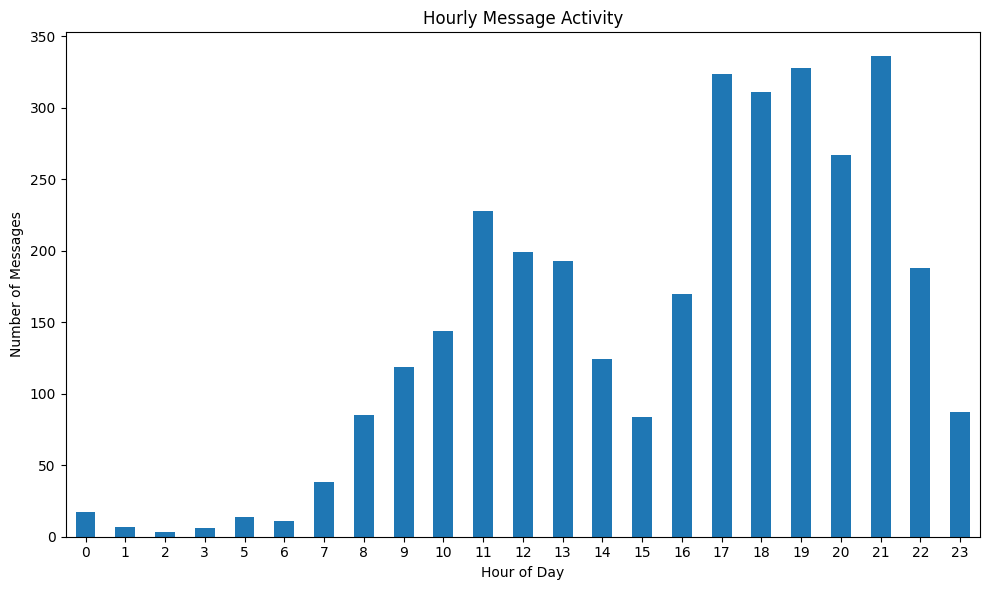

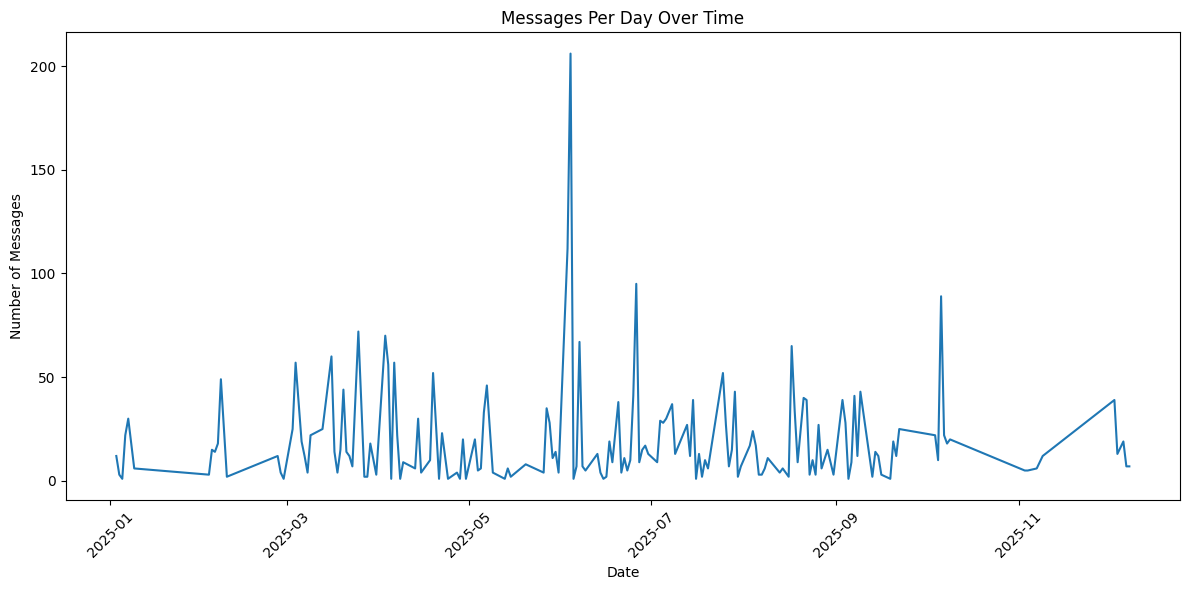

In [28]:
import matplotlib.pyplot as plt

# Plotting hourly activity
plt.figure(figsize=(10, 6))
hourly.plot(kind='bar')
plt.title('Hourly Message Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting messages per day
plt.figure(figsize=(12, 6))
messages_per_day.plot(kind='line')
plt.title('Messages Per Day Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
display(df['sentiment_label'].value_counts())

,count
sentiment_label,
neu,1911
pos,1187
neg,185


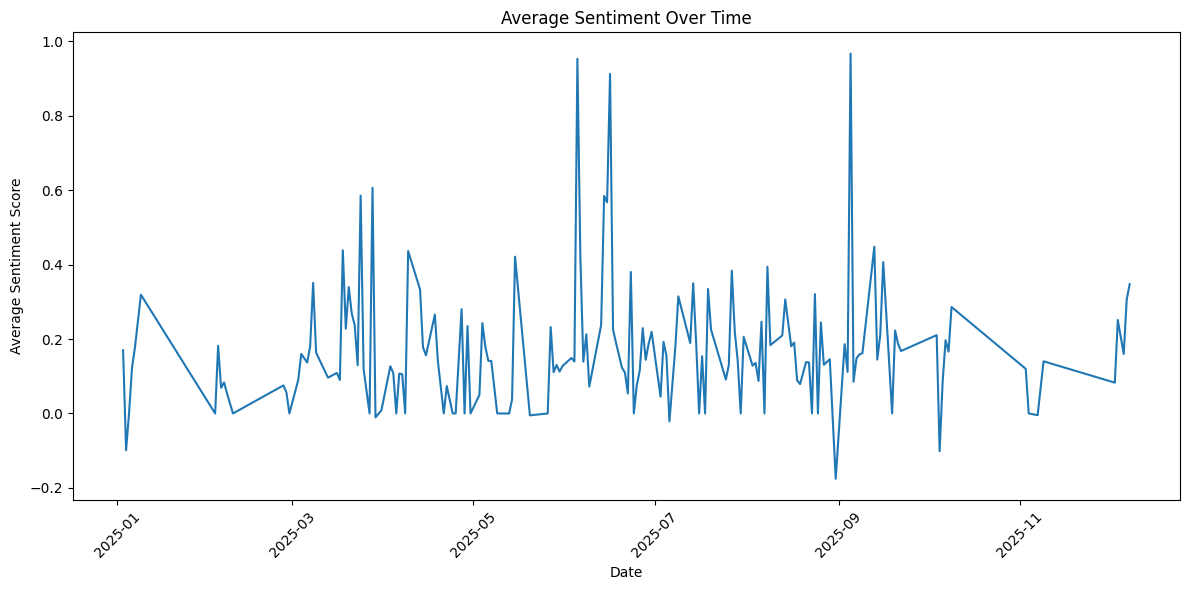

In [32]:
import matplotlib.pyplot as plt

# Calculate daily average sentiment
daily_sentiment = df.groupby('date_only')['sentiment_score'].mean()

# Plot sentiment over time
plt.figure(figsize=(12, 6))
daily_sentiment.plot(kind='line')
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

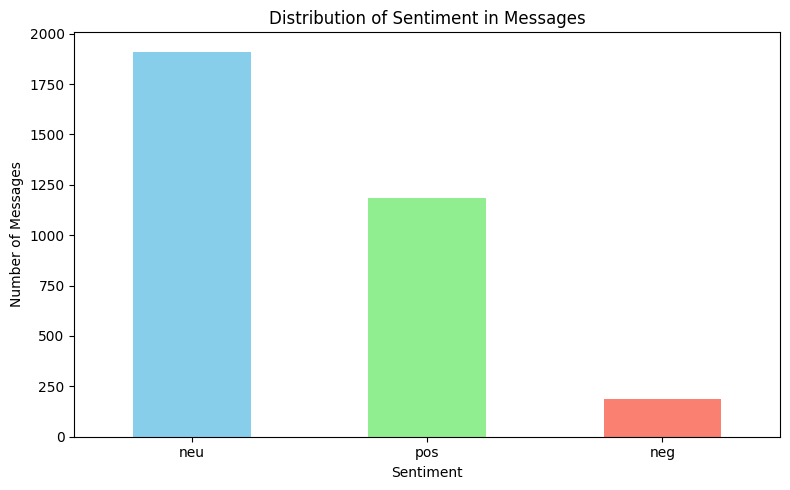

In [34]:
import matplotlib.pyplot as plt

# Get the sentiment counts
sentiment_counts = df['sentiment_label'].value_counts()

# Plotting the sentiment counts
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Sentiment in Messages')
plt.xlabel('Sentiment')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()